In [1]:
import numpy as np
import tensorflow as tf
import uproot
import awkward as ak
import vector
import numba as nb
import os
import fnmatch
from dnn_tau import Dnn_tau
from kinematic import *
from utils import isolate_int, normalize
import pandas as pd
from numbers import Number
from utils import normalize, split_dataset, bucketize
from data_extractor import Data_extractor_v1
import matplotlib.pyplot as plt

In [58]:
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST9/ttm/anatuple/"
extractor = Data_extractor_v1('ttm')
data = extractor(path)

In [60]:
N = len(data['event'])
n_bkg = N-sum([data['signal_label'][i] for i in range(len(data['signal_label']))])
data_norm = normalize(pd.DataFrame(data), 'mass_hyp', n_bkg)
data_norm = normalize(data_norm, 'signal_label', n_bkg)
print("Total background weight : ", sum(data_norm['genWeight'][i] for i in range(N) if data['signal_label'][i] == 0))
print("Total signal weight : ", sum(data_norm['genWeight'][i] for i in range(N) if data['signal_label'][i] == 1))
print("Number of background events : ", n_bkg)
print("Total number of events : ", N)
data_norm = normalize(data_norm, 'channel', n_bkg)

Total background weight :  801842.9999999836
Total signal weight :  801843.0000000069
Number of background events :  801843.0
Total number of events :  891987


In [61]:
data_processed, channel_indices = bucketize(data_norm, 'channel')
print(list(data_processed.keys()))

['event', 'genWeight', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'mass_hyp', 'signal_label', 'channel', 'event_type']


In [62]:
input_vars = ['deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'Mt_tot', 'channel', 'mass_hyp', 'signal_label']

In [63]:
model = Dnn_tau(input_vars)
model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./saved_models/checkpoint",
    monitor = "val_loss",
    save_best_only = True
)

In [64]:
train, val, test, meas = split_dataset(data_processed)
x_train = train[input_vars]
x_test = test[input_vars]
x_val = val[input_vars]
x_meas = meas[input_vars]

label_train = x_train.pop('signal_label').astype(float)
label_val = x_val.pop('signal_label').astype(float)
label_test = x_test.pop('signal_label').astype(float)
label_meas = x_meas.pop('signal_label').astype(float)

Total number of events :  891987
Train set : 37.58 %
Validation set : 12.53 %
Test set : 25.00 %
Measurement set : 24.90 %


In [65]:

history = model.fit(x_train, label_train, sample_weight=train['genWeight'], validation_data=(x_val, label_val), epochs=1000000, verbose=1, 
                    batch_size = 400, callbacks=[early_stopping, checkpoint])

Epoch 1/1000000
838/838 [==============================] - 6s 6ms/step - loss: 0.7975 - accuracy: 0.4850 - val_loss: 0.7045 - val_accuracy: 0.4961
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 2/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.5074 - accuracy: 0.5292 - val_loss: 0.6728 - val_accuracy: 0.5651
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 3/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.4725 - accuracy: 0.5603 - val_loss: 0.6641 - val_accuracy: 0.5603
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 4/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.4523 - accuracy: 0.5663 - val_loss: 0.6716 - val_accuracy: 0.5712
Epoch 5/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.4386 - accuracy: 0.5696 - val_loss: 0.6609 - val_accuracy: 0.5718
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 6/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.4270 - accuracy: 0.5795 - val_loss: 0.6323 - val_accuracy: 0.5886
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 7/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.4099 - accuracy: 0.5971 - val_loss: 0.6496 - val_accuracy: 0.5909
Epoch 8/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.4039 - accuracy: 0.6052 - val_loss: 0.6361 - val_accuracy: 0.6068
Epoch 9/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3959 - accuracy: 0.6135 - val_loss: 0.6289 - val_accuracy: 0.6156
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 10/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3861 - accuracy: 0.6163 - val_loss: 0.6177 - val_accuracy: 0.6220
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 11/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3813 - accuracy: 0.6334 - val_loss: 0.6071 - val_accuracy: 0.6527
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 12/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3789 - accuracy: 0.6437 - val_loss: 0.6283 - val_accuracy: 0.6410
Epoch 13/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3796 - accuracy: 0.6447 - val_loss: 0.6123 - val_accuracy: 0.6467
Epoch 14/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3772 - accuracy: 0.6413 - val_loss: 0.5947 - val_accuracy: 0.6531
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 15/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3769 - accuracy: 0.6517 - val_loss: 0.5957 - val_accuracy: 0.6532
Epoch 16/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3718 - accuracy: 0.6536 - val_loss: 0.6149 - val_accuracy: 0.6619
Epoch 17/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3735 - accuracy: 0.6594 - val_loss: 0.5775 - val_accuracy: 0.6758
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 18/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3731 - accuracy: 0.6585 - val_loss: 0.6324 - val_accuracy: 0.6534
Epoch 19/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3720 - accuracy: 0.6688 - val_loss: 0.6278 - val_accuracy: 0.6526
Epoch 20/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3720 - accuracy: 0.6679 - val_loss: 0.5892 - val_accuracy: 0.6645
Epoch 21/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3691 - accuracy: 0.6686 - val_loss: 0.6064 - val_accuracy: 0.6586
Epoch 22/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3720 - accuracy: 0.6654 - val_loss: 0.6081 - val_accuracy: 0.6540
Epoch 23/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3695 - accuracy: 0.6610 - val_loss: 0.6185 - val_accuracy: 0.6527
Epoch 24/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3654 - accuracy: 0.6663 - val_

INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 28/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3649 - accuracy: 0.6683 - val_loss: 0.5611 - val_accuracy: 0.6754
INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


INFO:tensorflow:Assets written to: ./saved_models/checkpoint/assets


Epoch 29/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3655 - accuracy: 0.6637 - val_loss: 0.5621 - val_accuracy: 0.6763
Epoch 30/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3637 - accuracy: 0.6656 - val_loss: 0.6125 - val_accuracy: 0.6597
Epoch 31/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3641 - accuracy: 0.6668 - val_loss: 0.5744 - val_accuracy: 0.6780
Epoch 32/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3636 - accuracy: 0.6796 - val_loss: 0.6077 - val_accuracy: 0.6759
Epoch 33/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3644 - accuracy: 0.6686 - val_loss: 0.6098 - val_accuracy: 0.6668
Epoch 34/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3633 - accuracy: 0.6709 - val_loss: 0.6123 - val_accuracy: 0.6587
Epoch 35/1000000
838/838 [==============================] - 5s 6ms/step - loss: 0.3624 - accuracy: 0.6729 - val_

In [66]:
model.save('./saved_models/TEST9_with_initial_vars_for_score_hist')

INFO:tensorflow:Assets written to: ./saved_models/TEST9_with_initial_vars_for_score_hist/assets


INFO:tensorflow:Assets written to: ./saved_models/TEST9_with_initial_vars_for_score_hist/assets


In [67]:
model = tf.keras.models.load_model("./saved_models/TEST9_with_initial_vars_for_score_hist")

_, train_acc = model.evaluate(x_train, label_train, verbose=0)
_, test_acc = model.evaluate(x_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.644, Test: 0.644


In [71]:
scores = model.predict(x_test)
output_test = pd.DataFrame({'scores':np.ravel(scores), 'genWeight':test['genWeight'], 'signal_label':label_test})

In [80]:
def plot_hist(dataframe, keys, keys_label, bins_list, normalize = True, mode='n_tauh', return_counts = False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if type(dataframe) == dict:
        data_pd = pd.DataFrame(dataframe)
    else:
        data_pd = dataframe.copy()

    sub_df = {}
    if mode == 'n_tauh':
        sub_df_keys =  ["signal", "bkg_0", "bkg_1", "bkg_2"]
        event_type_labels = ["signal", r"$background\ 0\times\tau_h$", r"$background\ 1\times\tau_h$", r"$background\ 2\times\tau_h$"]
        signal = data_pd.loc[data_pd['signal_label']==1]
        background = data_pd.loc[data_pd['signal_label']==0]
        background_0 = background.loc[background['n_tauh']==0]
        background_1 = background.loc[background['n_tauh']==1]
        background_2 = background.loc[background['n_tauh']==2]
        sub_df[sub_df_keys[0]] = signal
        sub_df[sub_df_keys[1]] = background_0
        sub_df[sub_df_keys[2]] = background_1
        sub_df[sub_df_keys[3]] = background_2
    elif mode == 'simple':
        sub_df_keys = ['Data']
        event_type_labels = [None]
        sub_df['Data'] = data_pd
    elif mode == 'simple_signal_label':
        sub_df_keys =  ["signal", "bkg"]
        event_type_labels = ['signal', 'background']
        signal = data_pd.loc[data_pd['signal_label'] == 1]
        background = data_pd.loc[data_pd['signal_label']==0]
        sub_df[sub_df_keys[0]] = signal
        sub_df[sub_df_keys[1]] = background
    else:
        raise ValueError(f"The mode {mode} is not valid")
    
    figs = []
    counts = []

    if type(keys) != list:
        keys = [keys]
        keys_label = [keys_label]
        bins_list = [bins_list]
    
    for i,key in enumerate(keys):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # dictionary for counts/errors
        sub_dicts = []
        for k in range(len(list(sub_df.keys()))):
            sub_dicts.append({'counts':[], 'errors':[]})
        counts_j = dict(zip(list(sub_df.keys()), sub_dicts))

        for j,event_type in enumerate(sub_df.keys()):
            
            df = sub_df[event_type]
            
            if 'genWeight' not in list(df.keys()):
                df['genWeight'] = np.ones_like(df[list(df.keys())[0]])
            print(key)
            print(i)
            print(list(df.keys()))
            c,b = np.histogram(df[key], bins=bins_list[i], weights=df['genWeight'])
            c2,_ = np.histogram(df[key], bins=bins_list[i], weights=df['genWeight']**2)
            if normalize:
                norm = np.sum(c)
                c /= norm
                c2 /= norm**2
            error = np.sqrt(c2)

            counts_j[event_type]['counts'] = c
            counts_j[event_type]['errors'] = error
            
            if event_type_labels[j] != None:
                ax.stairs(c, b, label=event_type_labels[j], linewidth=2)
            else:
                ax.stairs(c, b, linewidth=2)
            # ax.errorbar((b[1:]+b[:-1])/2, c, yerr = np.sqrt(c2), marker = '.',drawstyle = 'steps-mid', color=colors[j])
            ax.errorbar((b[1:]+b[:-1])/2, c, yerr = error,fmt='.', color='k', linewidth=1)
            ax.set_xlabel(keys_label[i])
            if mode != 'simple':
                ax.legend()
            ax.grid(True)
        figs.append(fig)
        counts.append(counts_j)
    if return_counts:
        return figs, counts
    return figs

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({"font.size": 16, "font.family": "serif"})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

scores
0
['scores', 'genWeight', 'signal_label']
scores
0
['scores', 'genWeight', 'signal_label']


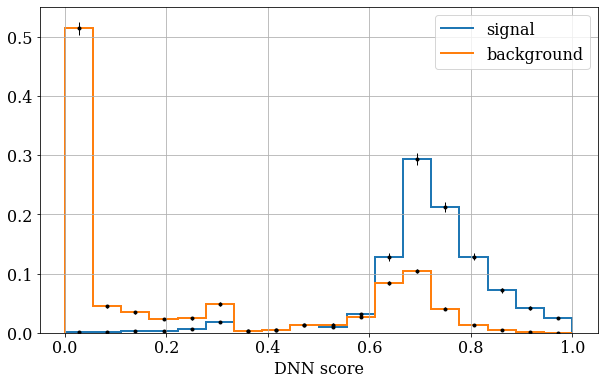

In [81]:
bins_list = np.linspace(0,1,19)
figs, counts = plot_hist(output_test, 'scores', 'DNN score', bins_list, normalize = True, mode='simple_signal_label', return_counts=True)
figs[0].savefig("Images/TEST9_ttm_score_hist.pdf")

In [91]:
bins_center = (bins_list[1:]+bins_list[:-1])/2
classed_bkg = (bins_center < 0.5)
values_s = counts[0]['signal']['counts']
values_b = counts[0]['bkg']['counts']
ratio_miss_s = values_s[classed_bkg].sum()/values_s.sum()
ratio_well_s = values_s[(1-classed_bkg).astype(bool)].sum()/values_s.sum()
ratio_miss_b = values_b[(1-classed_bkg).astype(bool)].sum()/values_b.sum()
ratio_well_b = values_b[classed_bkg].sum()/values_b.sum()
print("Missclassified signal : {:.2f}%".format(ratio_miss_s*100))
print("Correctly classified signal : {:.2f}%".format(ratio_well_s*100))
print("Missclassified background : {:.2f}%".format(ratio_miss_b*100))
print("Correctly classified background : {:.2f}%".format(ratio_well_b*100))


Missclassified signal : 5.47%
Correctly classified signal : 94.53%
Missclassified background : 28.85%
Correctly classified background : 71.15%
